## Loading Pcakages and Libraries



In [ ]:
import numpy as np
import pandas as pd
import pprint
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
pp = pprint.PrettyPrinter(indent=4,width=3)

from sklearn.decomposition import TruncatedSVD, PCA, NMF, LatentDirichletAllocation
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
import regex as re
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from itertools import combinations

!pip install umap-learn
import umap
!pip install -U "tmtoolkit[recommended,sklearn]"
from tmtoolkit.topicmod.evaluate import metric_coherence_gensim
import warnings
warnings.filterwarnings('ignore')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 63.0 MB/s eta 0:00:00
  Created wheel for globre: filename=globre-0.1.5-py3-none-any.whl size=19544 sha256=b4e18bd8171191276c4ac9c2e86e5ae8857e7af2f4949c40a0259684bbc44cf4
  Stored in directory: /root/.cache/pip/wheels/e6/c5/26/0d27e07d567b3b4e63a618efff19a2cdbab636ac1295d20206
Successfully built globre


## Load dataset and basic exploratory data analysis

In [ ]:
# Load dataset
splits = {'train': 'data/train-00000-of-00001.parquet', 'test': 'data/test-00000-of-00001.parquet'}
news_df = pd.read_parquet("hf://datasets/wangrongsheng/ag_news/" + splits["train"])
topic_names = ['World', 'Sports', 'Business', 'Sci/Tech']

# Print summary statistics and name of the 4 topics, note that the name of the 4 topics is not contained in the original dataset
# we get the names from https://paperswithcode.com/dataset/ag-news
print("Summary Statistics of AGNews dataset:")
print(news_df.describe())
print("\n Names of Topics:")
pp.pprint(topic_names)

Summary Statistics of AGNews dataset:
               label
count  120000.000000
mean        1.500000
std         1.118039
min         0.000000
25%         0.750000
50%         1.500000
75%         2.250000
max         3.000000

 Names of Topics:
[   'World',
    'Sports',
    'Business',
    'Sci/Tech']


In [ ]:
# integrate topic name into dataframe columns
news_df['Topic_name'] = news_df['label'].apply(lambda x: topic_names[x])

# print head rows of the dataset
news_df.head()

,text,label,Topic_name
0,Wall St. Bears Claw Back Into the Black (Reute...,2,Business
1,Carlyle Looks Toward Commercial Aerospace (Reu...,2,Business
2,Oil and Economy Cloud Stocks' Outlook (Reuters...,2,Business
3,Iraq Halts Oil Exports from Main Southern Pipe...,2,Business
4,"Oil prices soar to all-time record, posing new...",2,Business


Text(0.5, 0, 'Frequency')

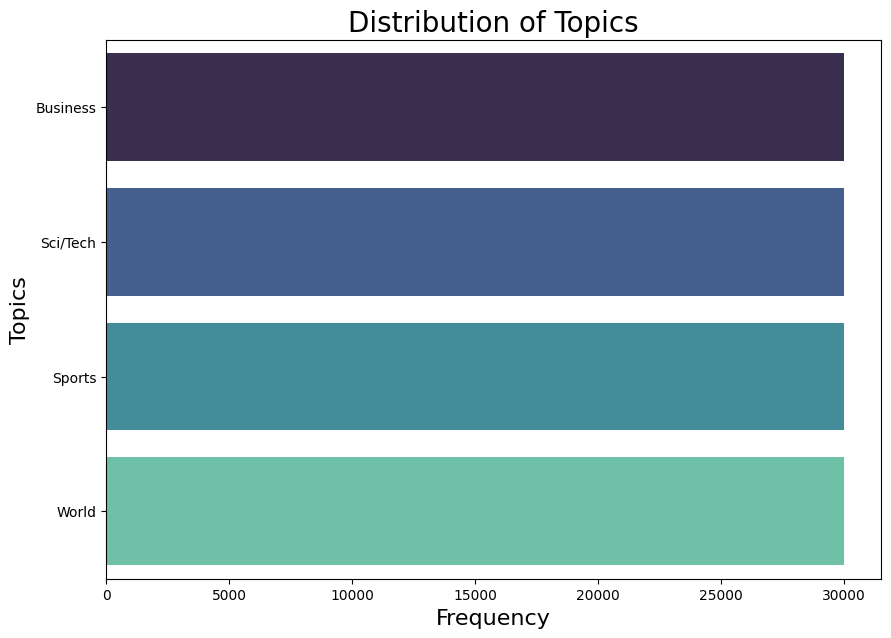

In [ ]:
# plot distribution of topics in news data
fig = plt.figure(figsize=[10,7])
ax = sns.countplot(y=news_df['Topic_name'], palette="mako")
plt.title('Distribution of Topics',fontsize=20)
plt.ylabel('Topics',fontsize=16)
plt.xlabel('Frequency',fontsize=16)

## Text Pre-Preprocessing and Featurization

In [ ]:
# Downloading necessary nltk resources
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt_tab')

# Clean raw text, this function draws inspiration from the kaggle notebook https://www.kaggle.com/code/sumantindurkhya/topic-modeling-on-20-newsgroup-data-lsa-and-lda.
def clean_text(text):
    """
    Preprocesses the input text by:
    - Lowercasing
    - Removing non-alphabetic characters
    - Tokenizing
    - Removing stopwords
    - Filtering out short words
    - Lemmatizing

    Returns a cleaned string.
    """

    def remove_non_alpha(text):
        """Remove non-alphabetic characters and extra spaces at the starting and trailing whitespace."""
        return re.sub(r'[^a-z\s]+', ' ', text).strip()

    def remove_stopwords(words):
        """Remove common stopwords."""
        stop_words = set(stopwords.words('english'))
        return [word for word in words if word not in stop_words]

    def lemmatize_words(words):
        """Lemmatize the list of words."""
        lemmatizer = WordNetLemmatizer()
        return [lemmatizer.lemmatize(word) for word in words]

    # Step 1: Lowercase and clean non-alphabetic characters
    text = text.lower()
    text = remove_non_alpha(text)

    # Step 2: Tokenize the cleaned text
    words = word_tokenize(text)

    # Step 3: Remove stopwords
    words = remove_stopwords(words)

    # Step 4: Filter out short words (length < 3)
    words = [word for word in words if len(word) > 2]

    # Step 5: Lemmatize the words
    words = lemmatize_words(words)

    # Step 6: Join the words back into a single string
    cleaned_text = ' '.join(words)

    return cleaned_text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [ ]:
# clean raw text data
tqdm.pandas()
news_df['text'] = news_df['text'].progress_apply(lambda x: clean_text(str(x)))

  0%|          | 0/120000 [00:00<?, ?it/s]

In [ ]:
news_df.head()

,text,label,Topic_name
0,wall bear claw back black reuters reuters shor...,2,Business
1,carlyle look toward commercial aerospace reute...,2,Business
2,oil economy cloud stock outlook reuters reuter...,2,Business
3,iraq halt oil export main southern pipeline re...,2,Business
4,oil price soar time record posing new menace e...,2,Business


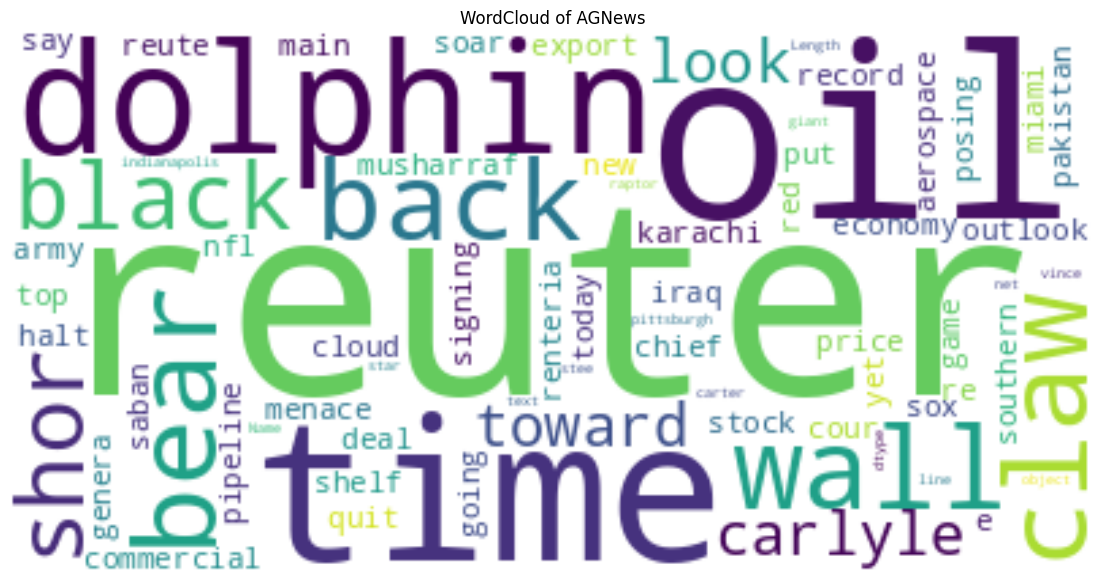

In [ ]:
# plot word count for news text
wordcloud = WordCloud(background_color='white',
                      max_words=500).generate(str(news_df['text']))
fig = plt.figure(figsize=[14,15])
plt.title('WordCloud of AGNews')
plt.axis('off')
plt.imshow(wordcloud,interpolation='bilinear')
plt.show()


In [ ]:
# featurize text data using tf-idf
tfid_vec = TfidfVectorizer(tokenizer=lambda x: str(x).split(), max_df=0.95, min_df=2)
X = tfid_vec.fit_transform(news_df['text'])
X.shape

(120000, 35000)

## Useful functions





In [ ]:
# function get the m most used words in the top n topics across all documnets, inspired by the kaggle notebook https://www.kaggle.com/code/sumantindurkhya/topic-modeling-on-20-newsgroup-data-lsa-and-lda
def map_word_2_top_n_topic(X, components, terms, top_n_topic=4, top_m_words=5):
    # create output series
    top_m_words_top_n_topics = pd.Series()

    # select top n used topics across all documents
    mean_topic = np.mean(X, axis=0)
    top_n_topic_idx = np.argsort(mean_topic)[::-1][:top_n_topic]
    top_n_topic_idx = top_n_topic_idx.tolist()

    for i in top_n_topic_idx:

      # select top m words within each of the top n topics
      component = components[i]
      topic_words = pd.Series(component, index=terms)
      topic_words.sort_values(ascending=False, inplace=True)
      top_m_words_top_n_topics['topic '+str(i+1)] = list(topic_words.iloc[:top_m_words].index)

    return top_m_words_top_n_topics

In [ ]:
# pairwise jaccard diversity score for topic model evaluation, adapted from https://github.com/silviatti/topic-model-diversity/blob/master/diversity_metrics.py
def pairwise_jaccard_diversity(topics, topk=10):
    '''
    compute the average pairwise jaccard distance between the topics

    Parameters
    ----------
    topics: a list of lists of words
    topk: top k words on which the topic diversity
          will be computed

    Returns
    -------
    pjd: average pairwise jaccard distance
    '''
    dist = 0
    count = 0
    for list1, list2 in combinations(topics, 2):
        js = 1 - len(set(list1).intersection(set(list2)))/len(set(list1).union(set(list2)))
        dist = dist + js
        count = count + 1
    return dist/count

## Non-negative matrix factorization (NMF)

In [ ]:
# Fit the NMF model to the TF-IDF matrix
nmf_model = NMF(n_components=4, random_state=20)
X_topics_nmf = nmf_model.fit_transform(X)  # Document-topic matrix
H_nmf = nmf_model.components_       # Topic-term matrix
terms = tfid_vec.get_feature_names_out() # name of the tf-idf features

In [ ]:
top_5_words_top_4_topics_nmf = map_word_2_top_n_topic(X_topics_nmf, H_nmf, terms)

# print topic results
print('Top 4 Topics\t\tTop 5 Words')
for idx, item in zip(top_5_words_top_4_topics_nmf.index, top_5_words_top_4_topics_nmf):
    print(idx,'\t',item)

Top 4 Topics		Top 5 Words
topic 1 	 ['new', 'microsoft', 'year', 'quot', 'company']
topic 4 	 ['iraq', 'killed', 'said', 'iraqi', 'baghdad']
topic 2 	 ['fullquote', 'reuters', 'stock', 'investor', 'http']
topic 3 	 ['oil', 'price', 'crude', 'stock', 'barrel']


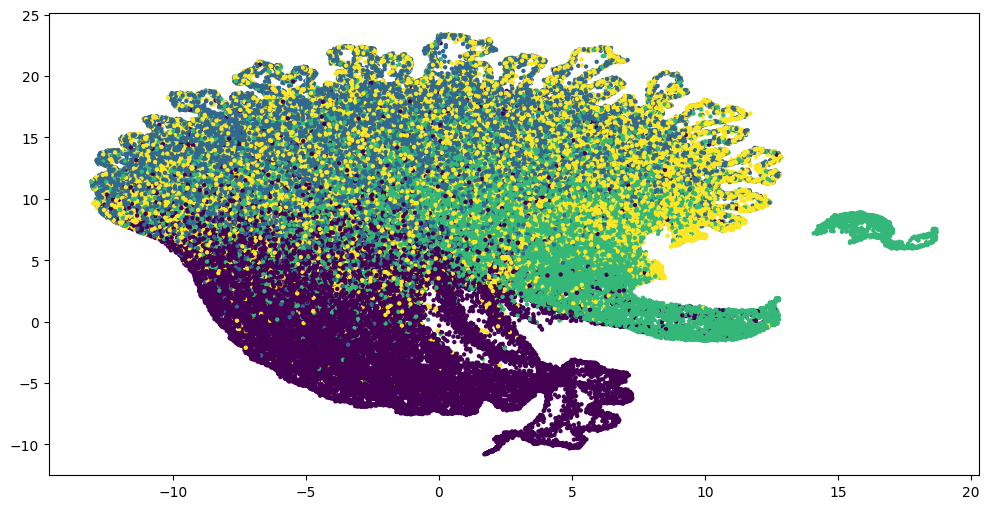

In [ ]:
# Visualizing the embeddings learnt for each document using UMAP
embedding = umap.UMAP(n_neighbors=150, min_dist=0.5, random_state=12).fit_transform(X_topics_nmf)
plt.figure(figsize=(12,6))
plt.scatter(embedding[:, 0], embedding[:, 1],
c = news_df["label"],
s = 10, # size
edgecolor='none' )
plt.show()

In [ ]:
# Quantitative metric for topic Modelling, the topic coherence (we use both u_mass and c_v coherence scores)
print("u_mass topic coherence score for NMF on AGNews is:")
print(metric_coherence_gensim(measure='u_mass',
                        top_n=20,
                        topic_word_distrib =H_nmf,
                        dtm = X,
                        vocab=terms,
                        return_mean = True))

print("\nc_v topic coherence score for NMF on AGNews is:")
print(metric_coherence_gensim(measure='c_v',
                        top_n=20,
                        topic_word_distrib =H_nmf,
                        dtm = X,
                        vocab=terms,
                        texts=[i.split(" ") for i in news_df["text"].tolist()],
                        return_mean = True))

top_200_words_in_topic_nmf = map_word_2_top_n_topic(X_topics_nmf, H_nmf, terms, top_n_topic=4, top_m_words=200)

print("\naverged jaccard diversity for NMF on AGNews is:")
print(pairwise_jaccard_diversity(top_200_words_in_topic_nmf.tolist(), topk=50))


u_mass topic coherence score for NMF on AGNews is:
-2.5868231912700224

c_v topic coherence score for NMF on AGNews is:
0.6461955708114884

averged jaccard diversity for NMF on AGNews is:
0.879738247926204


## Latent Semantic Analysis

In [ ]:
# create svd model for LSA
svd_model = TruncatedSVD(n_components=4, algorithm='randomized',random_state=20,n_iter=100)

# Fit the SVD model for LSA
X_topics_lsa = svd_model.fit_transform(X)
H_lsa = svd_model.components_


In [ ]:
top_5_words_top_4_topics_lsa = map_word_2_top_n_topic(X_topics_lsa, H_lsa, terms)

# print topic results
print('Top 4 Topics\t\tTop 5 Words')
for idx, item in zip(top_5_words_top_4_topics_lsa.index, top_5_words_top_4_topics_lsa):
    print(idx,'\t',item)

Top 4 Topics		Top 5 Words
topic 1 	 ['reuters', 'new', 'oil', 'said', 'stock']
topic 3 	 ['oil', 'price', 'crude', 'iraq', 'barrel']
topic 4 	 ['reuters', 'fullquote', 'iraq', 'killed', 'baghdad']
topic 2 	 ['stock', 'oil', 'fullquote', 'price', 'reuters']


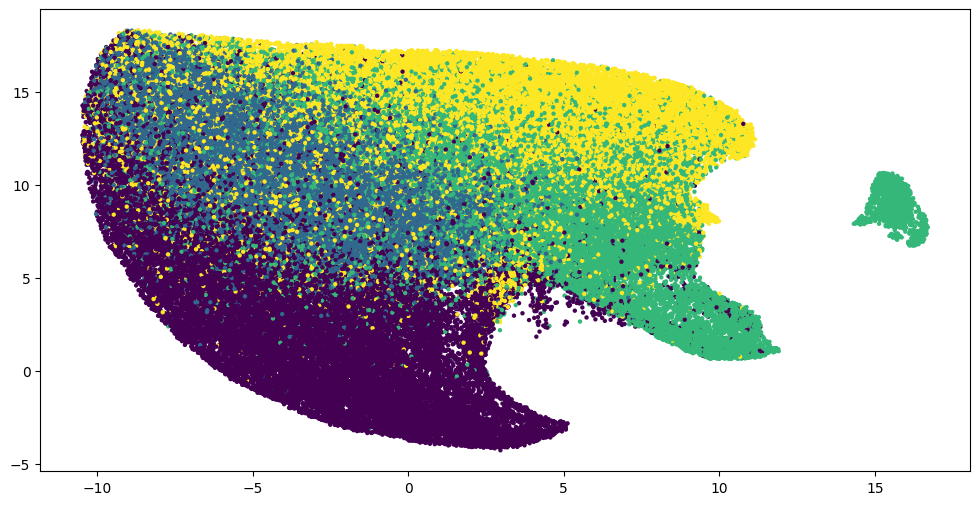

In [ ]:
embedding = umap.UMAP(n_neighbors=150, min_dist=0.5, random_state=12).fit_transform(X_topics_lsa)
plt.figure(figsize=(12,6))
plt.scatter(embedding[:, 0], embedding[:, 1],
c = news_df["label"],
s = 10, # size
edgecolor='none' )
plt.show()

In [ ]:
# Quantitative metric for topic Modelling, the topic coherence (we use both u_mass and c_v coherence scores)
print("u_mass topic coherence score for LSA on AGNews is:")
print(metric_coherence_gensim(measure='u_mass',
                        top_n=20,
                        topic_word_distrib =H_lsa,
                        dtm = X,
                        vocab=terms,
                        return_mean = True))

print("\nc_v topic coherence score for LSA on AGNews is:")
print(metric_coherence_gensim(measure='c_v',
                        top_n=20,
                        topic_word_distrib =H_lsa,
                        dtm = X,
                        vocab=terms,
                        texts=[i.split(" ") for i in news_df["text"].tolist()],
                        return_mean = True))

top_200_words_in_topic_lsa = map_word_2_top_n_topic(X_topics_lsa, H_lsa, terms, top_n_topic=4, top_m_words=200)

print("\naverged jaccard diversity for LSA on AGNews is:")
print(pairwise_jaccard_diversity(top_200_words_in_topic_lsa.tolist(), topk=50))

u_mass topic coherence score for LSA on AGNews is:
-4.293874683509897

c_v topic coherence score for LSA on AGNews is:
0.5452744293011563

averged jaccard diversity for LSA on AGNews is:
0.8126635502632119


## Latent Dirichlet Allocation (LDA)

In [ ]:
# Fit the LDA model
lda_model = LatentDirichletAllocation(n_components=4, max_iter=60, random_state=20)

# Fit and transform the LDA model
X_topics_lda = lda_model.fit_transform(X)
H_lda = lda_model.components_


In [ ]:
top_5_words_top_4_topics_lda = map_word_2_top_n_topic(X_topics_lda, H_lda, terms)

# print topic results
print('Top 4 Topics\t\tTop 5 Words')
for idx, item in zip(top_5_words_top_4_topics_lda.index, top_5_words_top_4_topics_lda):
    print(idx,'\t',item)

Top 4 Topics		Top 5 Words
topic 3 	 ['oil', 'new', 'price', 'reuters', 'stock']
topic 1 	 ['game', 'win', 'team', 'season', 'first']
topic 2 	 ['said', 'quot', 'union', 'court', 'new']
topic 4 	 ['iraq', 'said', 'killed', 'iraqi', 'president']


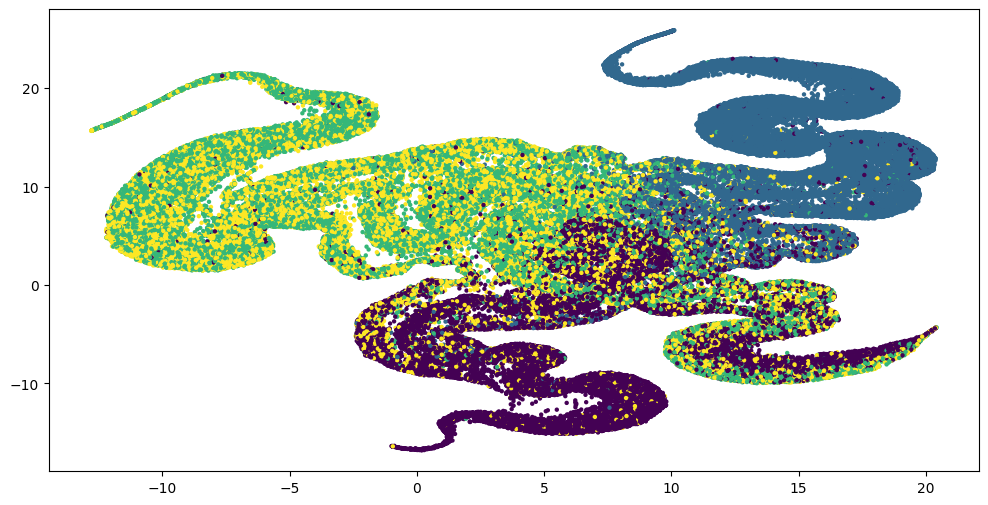

In [ ]:
embedding = umap.UMAP(n_neighbors=150, min_dist=0.5, random_state=12).fit_transform(X_topics_lda)
plt.figure(figsize=(12,6))
plt.scatter(embedding[:, 0], embedding[:, 1],
c = news_df["label"],
s = 10, # size
edgecolor='none' )
plt.show()

In [ ]:
# Quantitative metric for topic Modelling, the topic coherence (we use both u_mass and c_v coherence scores)
print("u_mass topic coherence score for LDA on AGNews is:")
print(metric_coherence_gensim(measure='u_mass',
                        top_n=20,
                        topic_word_distrib =H_lda,
                        dtm = X,
                        vocab=terms,
                        return_mean = True))

print("\nc_v topic coherence score for LDA on AGNews is:")
print(metric_coherence_gensim(measure='c_v',
                        top_n=20,
                        topic_word_distrib =H_lda,
                        dtm = X,
                        vocab=terms,
                        texts=[i.split(" ") for i in news_df["text"].tolist()],
                        return_mean = True))

top_200_words_in_topic_lda = map_word_2_top_n_topic(X_topics_lda, H_lda, terms, top_n_topic=4, top_m_words=200)

print("\naverged jaccard diversity for LDA on AGNews is:")
print(pairwise_jaccard_diversity(top_200_words_in_topic_lda.tolist(), topk=50))

u_mass topic coherence score for LDA on AGNews is:
-3.0625317623770862

c_v topic coherence score for LDA on AGNews is:
0.5213183283398759

averged jaccard diversity for LDA on AGNews is:
0.881109818684212
